# Distribution of BIRs in static networks

The aim of this notebook is to test the behavior of the algorithm observing the distribution of BIRs across six static directed networks.  
We will generate these synthetic networks using the built-in graph generators of NetworkX package: https://networkx.org/documentation/stable/reference/generators.html

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sys
sys.path.insert(1, '../python/src')

import BIRs

Let's write some helper functions

In [23]:
# Set base variables
levels_enum = ['top', 'strong', 'weak', 'branch', 'none']
roles_enum = ['emitter', 'amplifier', 'hub', 'reducer', 'receiver', 'isolated']
colors_enum = ['#3d8043', '#81b622', '#0e86d4', '#ffa500', '#d10000', '#282828']
level_colors = ['#d7301f', '#fc8d59', '#fdcc8a', '#FFA500', '#888']
role_colors = {r: colors_enum[i] for i, r in enumerate(roles_enum)}

def hex2rgb(c):
    """Hex 2 RGB"""
    h = c.lstrip('#')
    return list(int(h[i:i+2], 16) / 255 for i in (0, 2, 4))

def plot_graph(H, k=None, iterations=50):
    """Plot a NetworkX Graph"""
    # Detect basic influence roles (BIRs)
    rdata = BIRs.detect_nx(H)
    # Apply colors based on role data
    colors_data = {n['id']: hex2rgb(role_colors[n['role']]) for n in rdata}
    node_color = [colors_data[n] for n in H.nodes()]
    # Define layout parameters
    pos = nx.spring_layout(H, k=k, iterations=iterations, seed=16)
    # Customize node/edge styles (optional)
    node_size = [20 + (len(H[node]) * 40) for node in H]  # Scale node size by degree
    edge_color = ['gray' for _ in H.edges()]  # Set all edges to gray
    fig = plt.figure(1, figsize=(20, 8), dpi=60)
    nx.draw(
        H, pos, node_size=node_size, node_color=node_color, edge_color=edge_color,
        font_size=8, font_weight='bold', font_color='white', width=1.4,
        with_labels=False, arrows=True, arrowsize=10, # arrowstyle='->'
    )

def toDiGraph(H):
    """Create a directed graph from an undirected"""
    G = nx.DiGraph()
    G.add_nodes_from(list(H.nodes()))
    G.add_edges_from(list(H.edges()))
    return G

def getBIRsFrequencies(G):
    """Get BIRs frequencies given a network dataset"""
    # Remove possible self-loop edges
    G.remove_edges_from(nx.selfloop_edges(G))
    # Get basic influence roles
    roles = BIRs.detect_nx(G)
    # Calculate distributions
    distribution = BIRs.distribution(roles)
    # Prepare frequency data
    frequency = [dict(role=k, freq=v['frequency']) for k, v in distribution.items()]
    frequency.sort(key=lambda v: v['freq'], reverse=True)
    # Prepare frequency data of role's levels
    frequency_levels = [
        dict(role=k, level=kl, freq=vl['frequency'])
        for k, v in distribution.items()
        for kl, vl in v['levels'].items()
    ]
    frequency_levels.sort(key=lambda v: v['freq'], reverse=True)
    return roles, frequency, frequency_levels

def prepareResultsRoles(frequencies):
    """Prepare results of role frequencies"""
    freqs = {r['role']: r['freq'] for r in frequencies}
    return {k: freqs.get(k,0) for k in roles_enum}

def prepareResultsLevels(frequencies):
    """Prepare results of role frequencies"""
    return [
        [
            sum([r['freq'] for r in frequencies if r['role'] == k and r['level'] == l])
            for l in levels_enum
        ]
        for k in roles_enum
    ]

def plotHeatmap(datasets, rows, filename=None):
    """Plot heatmap"""
    sns.set_theme(context='paper')
    fig, ax = plt.subplots(figsize=(6,2))
    ax = sns.heatmap(
        np.around(np.array(rows), decimals=2),
        cmap="YlGnBu",
        annot=True,
        annot_kws={"size": 8},
        xticklabels=[r.title() for r in roles_enum],
        yticklabels=datasets,
        vmin=0, vmax=1,
        ax=ax
    )
    ax.xaxis.tick_top()
    ax.tick_params(left=False, top=False, bottom=False, right=False)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(size=0, labelsize=8)
    cbar.ax.margins(x=0, y=0, tight=True)
    ax.margins(x=0, y=0, tight=True)
    if filename: plt.savefig(filename, format="pdf", bbox_inches="tight", pad_inches=0)
    plt.show()

def plotHeatmapLevels(rows, filename=None):
    """Plot heatmap role levels"""
    sns.set_theme(context='paper')
    fig, ax = plt.subplots(figsize=(3,2))
    ax = sns.heatmap(
        np.around(np.array(rows), decimals=2),
        cmap="YlGnBu",
        annot=True,
        annot_kws={"size": 8},
        xticklabels=[l[0].upper() for l in levels_enum],
        yticklabels=[r.title() for r in roles_enum],
        vmin=0, vmax=1,
        ax=ax
    )
    ax.xaxis.tick_top()
    ax.tick_params(left=False, top=False, bottom=False, right=False)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(size=0, labelsize=8)
    cbar.ax.margins(x=0, y=0, tight=True)
    ax.margins(x=0, y=0, tight=True)
    if filename: plt.savefig(filename, format="pdf", bbox_inches="tight", pad_inches=0)
    plt.show()

Initialize base parameters

In [4]:
# Number of nodes
N = 100
seed = 268451

# Network datasets

### Erdős-Rényi (p=0.01)

In [6]:
erdos_renyi_graph = nx.erdos_renyi_graph(N, 0.01, seed=seed, directed=True)
# Get BIRs frequencies
erdos_renyi_roles, erdos_renyi_frequency, erdos_renyi_frequency_levels = getBIRsFrequencies(erdos_renyi_graph)
# Show role frequencies
pd.DataFrame(erdos_renyi_frequency)

,role,freq
0,emitter,0.28
1,receiver,0.24
2,hub,0.14
3,amplifier,0.13
4,reducer,0.12
5,isolated,0.09


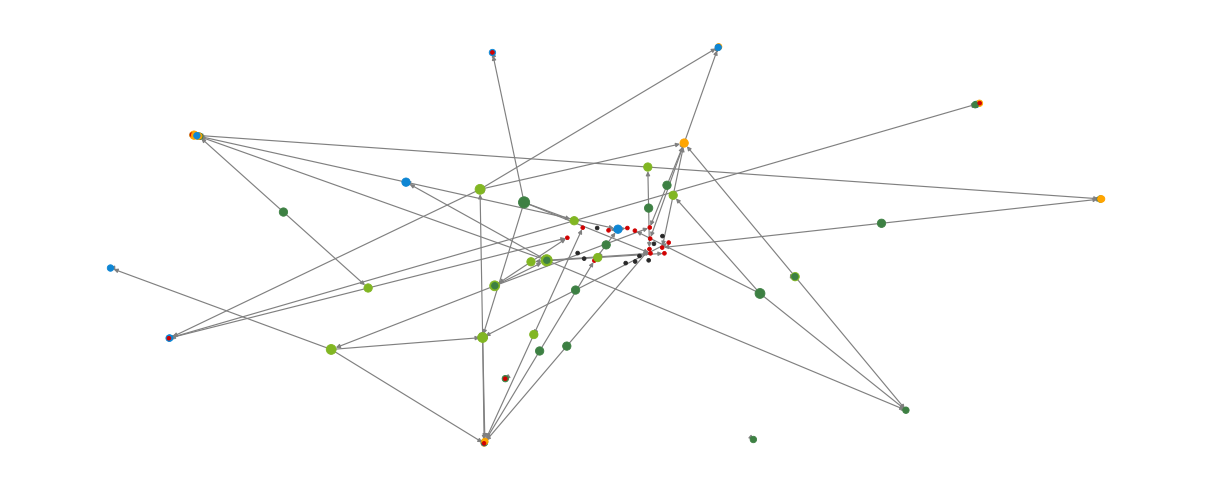

In [7]:
plot_graph(erdos_renyi_graph, k=0.02, iterations=1000)

### Erdős-Rényi Network (p=0.05)

In [8]:
erdos_renyi_graph2 = nx.erdos_renyi_graph(N, 0.05, seed=seed, directed=True)
# Get BIRs frequencies
erdos_renyi_roles2, erdos_renyi_frequency2, erdos_renyi_frequency_levels2 = getBIRsFrequencies(erdos_renyi_graph2)
# Show role frequencies
pd.DataFrame(erdos_renyi_frequency2)

,role,freq
0,hub,0.44
1,amplifier,0.34
2,reducer,0.19
3,receiver,0.02
4,emitter,0.01


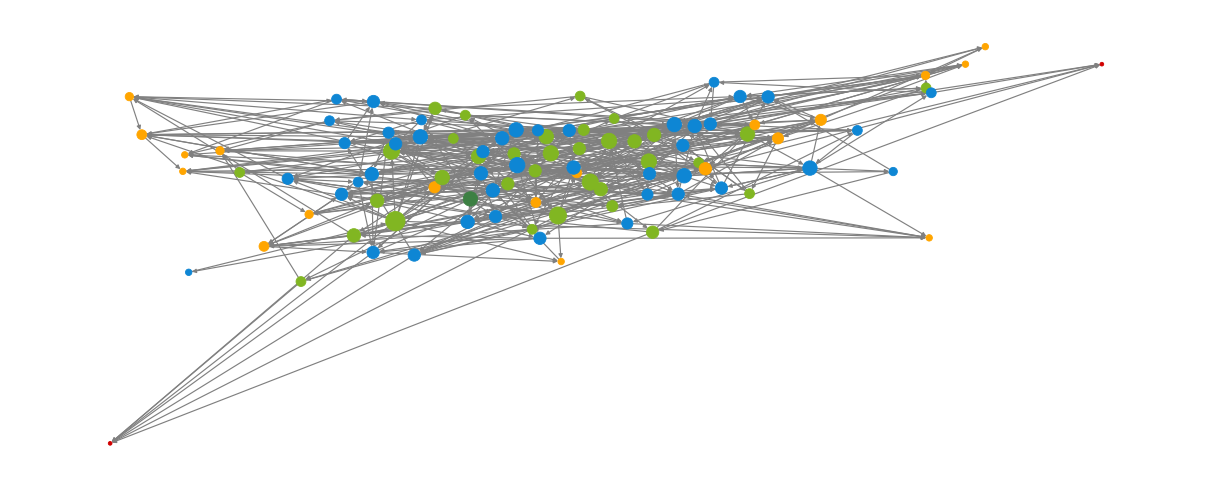

In [9]:
plot_graph(erdos_renyi_graph2, k=4, iterations=1000)

### Scale Free Network

In [10]:
scale_free_graph = nx.scale_free_graph(N, seed=seed)
# Get BIRs frequencies
scale_free_graph_roles, scale_free_frequency, scale_free_frequency_levels = getBIRsFrequencies(scale_free_graph)
# Show role frequencies
pd.DataFrame(scale_free_frequency)

,role,freq
0,emitter,0.75
1,receiver,0.09
2,reducer,0.07
3,hub,0.05
4,amplifier,0.04


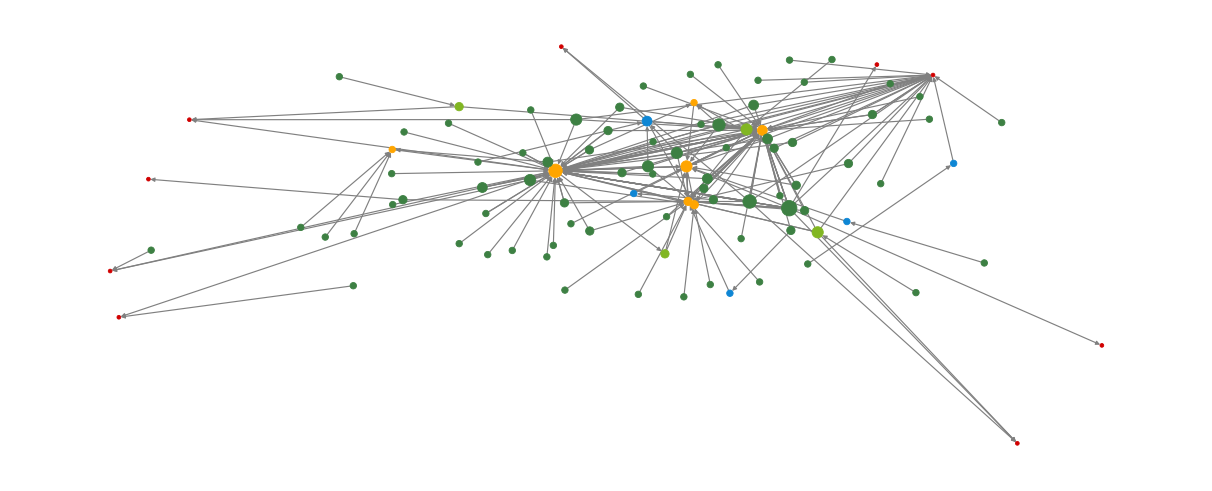

In [11]:
plot_graph(scale_free_graph, k=0.5, iterations=100)

### Watts-Strogatz Small-World Network

In [12]:
watts_strogatz_graph = toDiGraph(nx.watts_strogatz_graph(N, 2, 0.1, seed=seed))
# Get BIRs frequencies
watts_strogatz_roles, watts_strogatz_frequency, watts_strogatz_frequency_levels = getBIRsFrequencies(watts_strogatz_graph)
# Show role frequencies
pd.DataFrame(watts_strogatz_frequency)

,role,freq
0,hub,0.78
1,emitter,0.10
2,reducer,0.06
3,receiver,0.04
4,amplifier,0.02


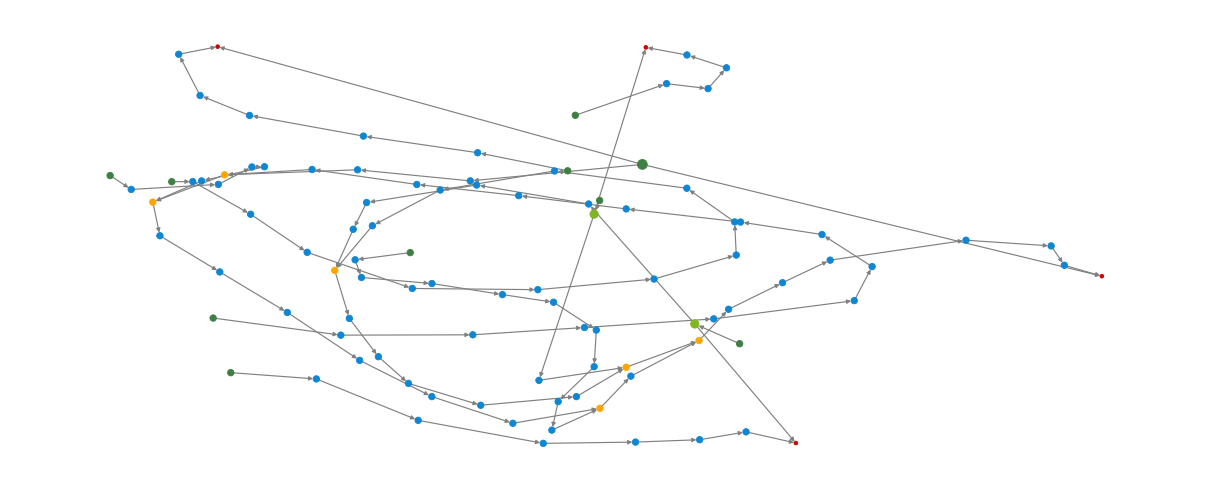

In [13]:
plot_graph(watts_strogatz_graph, k=1, iterations=400)

### Navigable Small-World Network

In [14]:
navigable_small_world_graph = nx.navigable_small_world_graph(N, p=1, q=1, r=2, dim=1, seed=seed)
# Get BIRs frequencies
navigable_small_world_roles, navigable_small_world_frequency, navigable_small_world_frequency_levels = getBIRsFrequencies(navigable_small_world_graph)
# Show role frequencies
pd.DataFrame(navigable_small_world_frequency)

,role,freq
0,hub,0.55
1,amplifier,0.23
2,reducer,0.22


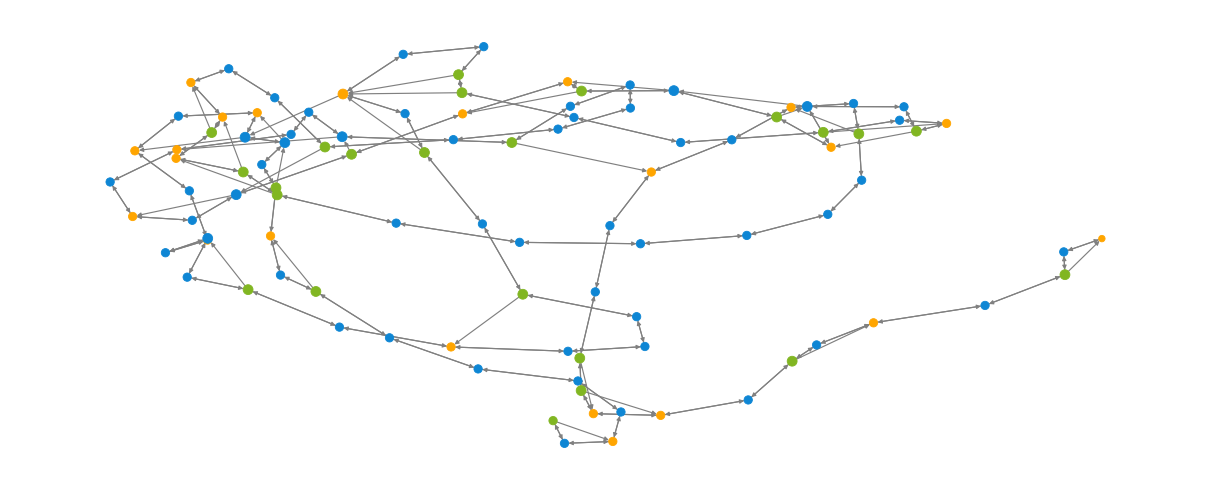

In [15]:
plot_graph(navigable_small_world_graph, k=1, iterations=300)

### Random Labeled Rooted Forest Network

In [16]:
random_labeled_rooted_forest = toDiGraph(nx.random_labeled_rooted_forest(N, seed=seed))
# Get BIRs frequencies
random_labeled_rooted_forest_roles, random_labeled_rooted_forest_frequency, random_labeled_rooted_forest_frequency_levels = getBIRsFrequencies(random_labeled_rooted_forest)
# Show role frequencies
pd.DataFrame(random_labeled_rooted_forest_frequency)

,role,freq
0,emitter,0.37
1,receiver,0.37
2,hub,0.13
3,amplifier,0.10
4,reducer,0.03


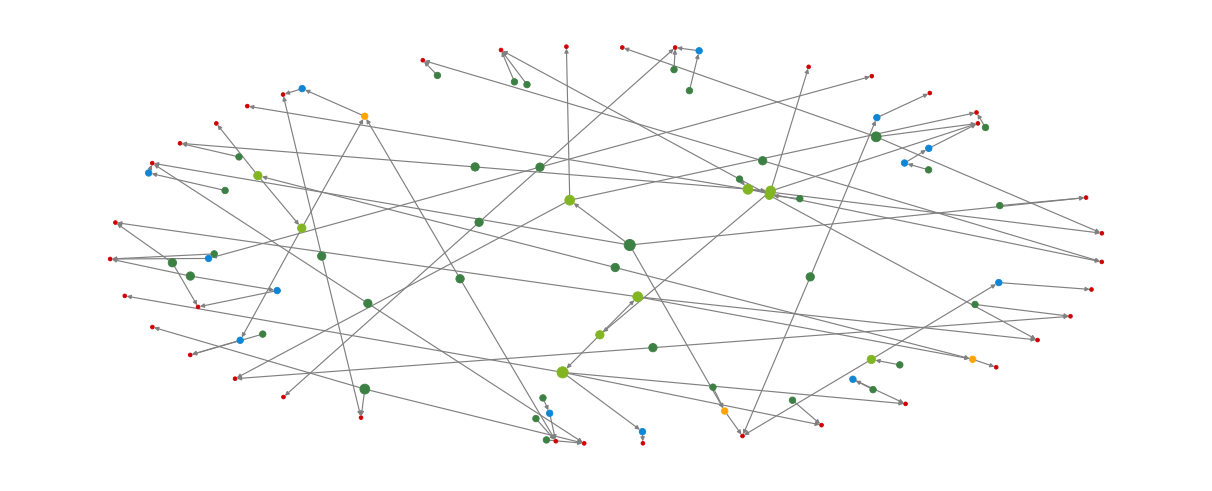

In [17]:
plot_graph(random_labeled_rooted_forest, k=2, iterations=1000)

## Comparing results

In [18]:
results = pd.DataFrame([
    dict(dataset='Erdős-Rényi 1', nodes=erdos_renyi_graph.number_of_nodes(), edges=erdos_renyi_graph.number_of_edges(), density=nx.density(erdos_renyi_graph)),
    dict(dataset='Erdős-Rényi 2', nodes=erdos_renyi_graph2.number_of_nodes(), edges=erdos_renyi_graph2.number_of_edges(), density=nx.density(erdos_renyi_graph2)),
    dict(dataset='Scale-Free', nodes=scale_free_graph.number_of_nodes(), edges=scale_free_graph.number_of_edges(), density=nx.density(scale_free_graph)),
    dict(dataset='Watts-Strogatz Small World', nodes=watts_strogatz_graph.number_of_nodes(), edges=watts_strogatz_graph.number_of_edges(), density=nx.density(watts_strogatz_graph)),
    dict(dataset='Navigable Small World', nodes=navigable_small_world_graph.number_of_nodes(), edges=navigable_small_world_graph.number_of_edges(), density=nx.density(navigable_small_world_graph)),
    dict(dataset='Random Rooted Forest', nodes=random_labeled_rooted_forest.number_of_nodes(), edges=random_labeled_rooted_forest.number_of_edges(), density=nx.density(random_labeled_rooted_forest)),
]).fillna(0)
results

,dataset,nodes,edges,density
0,Erdős-Rényi 1,100,103,0.010404
1,Erdős-Rényi 2,100,457,0.046162
2,Scale-Free,100,207,0.020909
3,Watts-Strogatz Small World,100,100,0.010101
4,Navigable Small World,100,229,0.023131
5,Random Rooted Forest,100,98,0.009899


In [19]:
results = pd.DataFrame([
    dict(dataset='Erdős-Rényi 1', **prepareResultsRoles(erdos_renyi_frequency)),
    dict(dataset='Erdős-Rényi 2', **prepareResultsRoles(erdos_renyi_frequency2)),
    dict(dataset='Scale-Free', **prepareResultsRoles(scale_free_frequency)),
    dict(dataset='Watts-Strogatz Small World', **prepareResultsRoles(watts_strogatz_frequency)),
    dict(dataset='Navigable Small World', **prepareResultsRoles(navigable_small_world_frequency)),
    dict(dataset='Random Rooted Forest', **prepareResultsRoles(random_labeled_rooted_forest_frequency))
]).fillna(0)
results

,dataset,emitter,amplifier,hub,reducer,receiver,isolated
0,Erdős-Rényi 1,0.28,0.13,0.14,0.12,0.24,0.09
1,Erdős-Rényi 2,0.01,0.34,0.44,0.19,0.02,0.00
2,Scale-Free,0.75,0.04,0.05,0.07,0.09,0.00
3,Watts-Strogatz Small World,0.10,0.02,0.78,0.06,0.04,0.00
4,Navigable Small World,0.00,0.23,0.55,0.22,0.00,0.00
5,Random Rooted Forest,0.37,0.10,0.13,0.03,0.37,0.00


In [20]:
cols = results['dataset'].to_list()

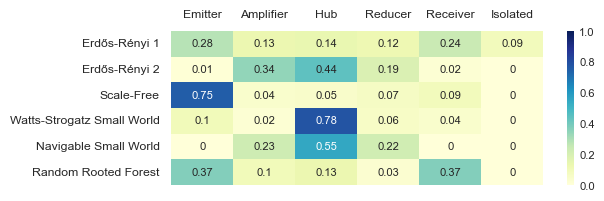

In [24]:
rows = results[[c for c in results.columns if c != 'dataset']].to_numpy()
plotHeatmap(cols, rows)

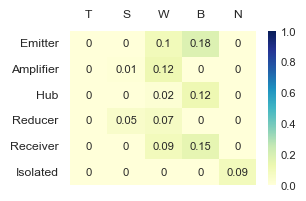

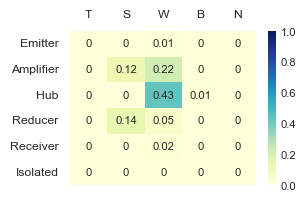

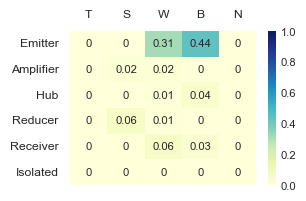

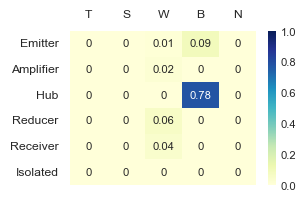

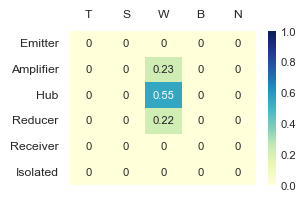

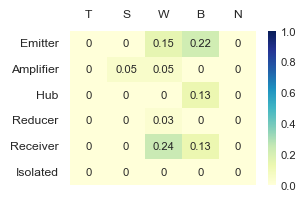

In [25]:
plotHeatmapLevels(prepareResultsLevels(erdos_renyi_frequency_levels))
plotHeatmapLevels(prepareResultsLevels(erdos_renyi_frequency_levels2))
plotHeatmapLevels(prepareResultsLevels(scale_free_frequency_levels))
plotHeatmapLevels(prepareResultsLevels(watts_strogatz_frequency_levels))
plotHeatmapLevels(prepareResultsLevels(navigable_small_world_frequency_levels))
plotHeatmapLevels(prepareResultsLevels(random_labeled_rooted_forest_frequency_levels))